In [110]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import reduce

In [2]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


# Utility Functions

In [3]:
def load_pkl(path):
    return pickle.load(open(path, "rb"))

In [4]:
def load_data(data):
    keys = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']
    x = data[keys[2]] # noisy sequences will be our input to our models
    y = data[keys[0]]
    y_viterbi_decoded = data[keys[3]]
    
    x = np.array(x)
    y = np.array(y)
    y_viterbi_decoded = np.array(y_viterbi_decoded)
    
    return x, y, y_viterbi_decoded

In [5]:
def load(path):
    return load_data(load_pkl(path))

In [114]:
def load_pkl_paths_from_folder(dir_path, recursive=False):
    if recursive:
        return list(filter(lambda x: ".pkl" in x,
                            [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(dir_path)) 
                                                 for f in fn]))
    else:
        return [dir_path + "/" + x for x in os.listdir(dir_path) if ".pkl" in x ]

In [7]:
def get_param_from_filename(filename, param):
    split_token = "_"
    if param == "k":
        split_token = "_k"
    elif param == "p":
        split_token = "_p"
    elif param == "r":
        split_token = "_r"
    elif param == "l":
        split_token = "_l"
    elif param == "e":
        split_token = "_e"
    elif param == "n":
        split_token = "_n"
    else:
        raise ValueError("unrecognized parameter", param)
        
    res = filename.split("/")[-1].split(split_token)[1].split("_")[0]
    if ".pkl" in res:
        res = res.split(".pkl")[0]
    
    return float(res)

# Data Processing

In [330]:
def train_test_split(x, y, test_ratio=0.2):
    indicies = np.arange(len(x))
    np.random.shuffle(indicies)
    
    split_inx = int(len(x) * (1-test_ratio))
    X_train, X_test = x[indicies[:split_inx]], x[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    
    return X_train, X_test, y_train, y_test

# Model Definitions

Optimizers

In [9]:
optimizers = {
    "adam": Adam, 
    "sgd":  SGD
}

Fully Connected Neural Net

In [10]:
default_fnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.01,
    "learing_rate": 0.015,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [11]:
default_fnn_architecture = [32,64,100]

Convolution 1D Nerual Net

In [12]:
default_cnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

Avaliable Layers:

Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D

In [ ]:
filters=16, kernel_size=3, strides=1,padding=PADDING, 
                 activation=ACTIVATION, input_shape=X_train_reshaped.shape[1:]

In [13]:
default_cnn_architecture = [
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("conv1d", dict(f=16,k=3,s=1)),
    ("flatten"),
    ("dense", 200),
    ("dropout")
]

# Model Construction

In [309]:
def build_fnn(input_shape, 
              output_shape, 
              architecture=default_fnn_architecture, 
              param=default_fnn_param):
    """
    Train a FNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, output_units in enumerate(architecture):
        if i == 0:
            model.add(Dense(output_units, activation=param["activation"],
                        input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
        else:
            model.add(Dense(output_units, activation=param["activation"],
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [435]:
def train_fnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

In [ ]:
def build_cnn(input_shape, 
              output_shape, 
              architecture=default_cnn_architecture, 
              param=default_cnn_param):
    """
    Train a CNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, layer in enumerate(architecture):
        if layer[0] == "conv1d":
            model.add(Conv1D(filters=16, kernel_size=3, strides=1,padding=PADDING, activation=ACTIVATION))
        elif layer[0] == "flatten":
            model.add(Flatten())
        elif layer[0] == "dense":
            model.add(Dense(layer[1], activation=param["activation"]))
        elif layer[0] == "dropout":
            model.add(Dropout(param["dropout_keep_prob"]))
        else:
            raise ValueError("do not recognize layer", layer[0])
    
#     for i, output_units in enumerate(architecture):
#         if i == 0:
#             model.add(Dense(output_units, activation=param["activation"],
#                         input_shape=input_shape,
#                         kernel_regularizer=regularizers.l2(param["l2_strength"])))
#         else:
#             model.add(Dense(output_units, activation=param["activation"],
#                         kernel_regularizer=regularizers.l2(param["l2_strength"])))
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [ ]:
def train_cnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

# Evaluation Metrics

In [802]:
def accuracy(y, y_pred, argmax=False, viterbi=False):
    y_pred_binary = y_pred
    
    if viterbi:
        y_pred_binary = [p[:y.shape[1]] for p in y_pred]
    elif argmax:
        y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
        assert y.shape == y_pred_binary.shape, "prediction and ground truth must \
        have same shape\nExpected:{0} Actual:{1}".format(y.shape, y_pred_binary.shape)
    
    return np.sum(y == y_pred_binary) / np.product(y.shape)

In [803]:
def model_accuracy(model, x, y, argmax=False):
    if argmax:
        y_pred = model.predict(x)
        return accuracy(y, y_pred, argmax)
    else:
        return model.evaluate(x, y, verbose=0)

In [804]:
def pred_vs_truth(model, x, y, n_show=2):
    indicies = np.random.randint(low=0, high=x.shape[0], size=n_show)
    y_pred = model.predict(x[indicies])
    y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
    
    truth = y[indicies].astype(y_pred_binary.dtype)
    for i in range(len(truth)):
        print("\n############## Example {0} ##############".format(i))
        print("Expected:\n", truth[i])
        print("Actual:\n", y_pred_binary[i])

# Experiments

In [1]:
def one_hot(data):
    res = []
    for d in data:
        res.append([0,0])
        res[-1][int(d)] = 1
    return np.array(res)

def one_hot_datasets(y):
    return np.array(list(map(lambda x: one_hot(x), y)))

def onehot_to_normal(dataset):
    return np.argmax(dataset, axis=2)

data_sources = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']

In [806]:
def build_experiment_data(experiment_type, k, data_source, combine_all=True, verbose=True):
    if "exp_" not in experiment_type:
        experiment_type = "exp_{0}".format(experiment_type)
        if len(experiment_type) != 5:
            raise ValueError("experiment_type has be of type: exp_X")
    data = all_exp_data[experiment_type]
    var = experiment_type[4]
    if verbose:
        print("building data for experiment {0} on variable {1} with k = {2}...".format(
                experiment_type, var, k))
    x, y = dict(), dict()
    for d, v in data.items():
        if k is not None and d[0] != k:
            continue
        var_value = d["kpel".index(var)]
        if var_value not in x: 
            x[var_value] = list()
            y[var_value] = list()
        x[var_value].append(v["noisy_seqs"])
        y[var_value].append(v["message_seqs"])
    for v in x:
        x[v] = np.vstack(x[v])
        y[v] = np.vstack(y[v])
    if verbose:
        print("... finished building data")
        
    if combine_all:
        return np.vstack(list(x.values())), np.vstack(list(y.values()))
    else:
        return x, y

In [807]:
def conduct_experiment(experiment_type, data_source, verbose=False,
                       architecture=default_fnn_architecture, 
                       param=default_fnn_param, average_N=5):
    if "exp_" not in experiment_type:
        experiment_type = "exp_{0}".format(experiment_type)
        if len(experiment_type) != 5:
            raise ValueError("experiment_type has be of type: exp_X")
    
    if experiment_type != "exp_k":
        ks = list(set(map(lambda x: x[0],list(data_source[experiment_type].keys()))))
        res = dict()
        for k in sorted(ks):
            if verbose:
                print("Performing experiments over k = {0}".format(k))
            x, y = build_experiment_data(experiment_type, k, all_exp_data, 
                                             combine_all=False, verbose=False)

            res[k] = dict()
            for var_value in sorted(x):
                if verbose:
                    print("... variable = {0}".format(var_value))
                res[k][var_value] = dict(acc=list(), best_model=None, avg_acc=0)
                for i in range(average_N):
                    if verbose:
                        print("... ... run {0}/{1}".format(i+1, average_N), end="\r")
                    X_train, X_test, y_train, y_test = train_test_split(x[var_value], y[var_value])
                    y_train = one_hot_datasets(y_train)
                    model = build_fnn(input_shape=X_train.shape[1:], output_shape=y_train.shape[1:],
                          architecture=architecture, param=param)
                    model = train_fnn(model, X_train, y_train, param=fnn_param)
                    acc = model_accuracy(model, X_test, y_test, argmax=True)

                    res[k][var_value]["acc"].append(acc)
                    if acc >= max(res[k][var_value]["acc"]):
                        res[k][var_value]["best_model"] = model
                res[k][var_value]["avg_acc"] = np.mean(res[k][var_value]["acc"])
                if verbose:
                    print("... finished with avg_acc of {0:.4f}".format(
                        res[k][var_value]["avg_acc"]))
    else:
        res = dict()
        if verbose:
            print("Performing experiments for exp_k ...")
        x, y = build_experiment_data(experiment_type, None, all_exp_data, 
                                         combine_all=False, verbose=False)
        for var_value in sorted(x):
            if verbose:
                print("... variable = {0}".format(var_value))
            res[var_value] = dict(acc=list(), best_model=None, avg_acc=0)
            for i in range(average_N):
                if verbose:
                    print("... ... run {0}/{1}".format(i+1, average_N), end="\r")
                X_train, X_test, y_train, y_test = train_test_split(x[var_value], y[var_value])
                y_train = one_hot_datasets(y_train)
                model = build_fnn(input_shape=X_train.shape[1:], 
                                  output_shape=y_train.shape[1:],
                                  architecture=architecture, 
                                  param=param)
                model = train_fnn(model, X_train, y_train, param=fnn_param)
                acc = model_accuracy(model, X_test, y_test, argmax=True)

                res[var_value]["acc"].append(acc)
                if acc >= max(res[var_value]["acc"]):
                    res[var_value]["best_model"] = model
            res[var_value]["avg_acc"] = np.mean(res[var_value]["acc"])
            if verbose:
                print("... ... finished with avg_acc of {0:.4f}".format(
                    res[var_value]["avg_acc"]))
            
    return res

In [808]:
def show_experiment_result(experiment_type, res, k, var_value, data_source, n_show=5):
    x, y = build_experiment_data(experiment_type, k, data_source, 
                                 combine_all=False, verbose=False)
    X_train, X_test, y_train, y_test = train_test_split(x[var_value], y[var_value])
    pred_vs_truth(res[k][var_value]["best_model"], X_test, y_test, n_show=n_show)

In [809]:
variable_desc = {
    "k": "message length (K-bit)",
    "p": "prob P of Bernoulli distribution",
    "e": "corruption probability E",
    "l": "constraint length L"
}

In [866]:
def graph_experiment_accuracy(res, title, variable_name, 
                              xlabel, ylabel, isK=False, 
                              c=["b-", "c-","m-","r-"]):
    plt.figure(figsize=(8, 5))
    plt.title(title)
    
    c_i = 0
    if isK:
        x_range = np.array(list(res.keys()))
        y_range = np.array(list(map(lambda x: res[x]["avg_acc"], res)))

        sorted_indicies = np.argsort(x_range)

        plt.plot(x_range[sorted_indicies], 
                 y_range[sorted_indicies], 
                 c[c_i],
                 label="FNN")
        c_i+=1
        
        # Graph Viterbi
        root_path_format = "../data/dataset_03/exp_k"
        exp_path = root_path_format.format(variable_name)
        viterbi_accuracies = list()
        plt_range = list()
        for pkl in load_pkl_paths_from_folder(exp_path, recursive=True):
            x, y, y_viterbi_decoded = load(pkl)
            acc = accuracy(y, y_viterbi_decoded, viterbi=True)
            viterbi_accuracies.append(acc)
            plt_range.append(get_param_from_filename(pkl, variable_name))

        sorted_indicies = np.argsort(plt_range)
        plt_range = np.array(plt_range)
        viterbi_accuracies = np.array(viterbi_accuracies)
        
        plt.plot(plt_range[sorted_indicies], 
                     viterbi_accuracies[sorted_indicies], 
                     c[c_i],
                     label="viterbi")
        c_i+=1
    else:
        for i, k in enumerate(res):
            x_range = np.array(list(res[k].keys()))
            y_range = np.array(list(map(lambda x: res[k][x]["avg_acc"], res[k])))

            sorted_indicies = np.argsort(x_range)

            plt.plot(x_range[sorted_indicies], 
                     y_range[sorted_indicies], 
                     c[c_i],
                     label="FNN k={0}".format(k))
            
            c_i+=1
            
            # Graph Viterbi
            root_path_format = "../data/dataset_03/exp_{0}/k{1}"
            exp_path = root_path_format.format(variable_name, k)
            viterbi_accuracies = list()
            plt_range = list()
            for pkl in load_pkl_paths_from_folder(exp_path, recursive=True):
                x, y, y_viterbi_decoded = load(pkl)
                acc = accuracy(y, y_viterbi_decoded, viterbi=True)
                viterbi_accuracies.append(acc)
                plt_range.append(get_param_from_filename(pkl, variable_name))
            
            sorted_indicies = np.argsort(plt_range)
            plt_range = np.array(plt_range)
            viterbi_accuracies = np.array(viterbi_accuracies)
            
            plt.plot(plt_range[sorted_indicies], 
                     viterbi_accuracies[sorted_indicies], 
                     c[c_i],
                     label="viterbi k={0}".format(k))
            c_i+=1
            
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

### Accuracy of viterbi decoding over different variables

In [862]:
def graph_viterbi_accuracy(dir_path, variable_name, xlabel=None, c="go"):
    if variable_name not in ["k", "p", "e", "l", "r"]:
        raise ValueError("unrecognized variable: {0}".format(variable_name))
    accuracies = list()
    plt_range = list()
    for pkl in load_pkl_paths_from_folder(dir_path, recursive=True):
        x, y, y_viterbi_decoded = load(pkl)
        acc = accuracy(y, y_viterbi_decoded, viterbi=True)
        accuracies.append(acc)
        plt_range.append(get_param_from_filename(pkl, variable_name))
        
    
    sorted_indices = np.argsort(accuracies)
    
    accuracies = np.array(accuracies)[sorted_indices]
    plt_range = np.array(plt_range)[sorted_indices]
    
    plt.title("Accuracy of viterbi decoding over vs. message length {0}".format(variable_name.upper()))
    if xlabel is None: xlabel = variable_name
    plt.xlabel(xlabel)
    plt.ylabel("viterbi decoding accuracy")
    plt.plot(plt_range, accuracies, c)
    return accuracies, plt_range

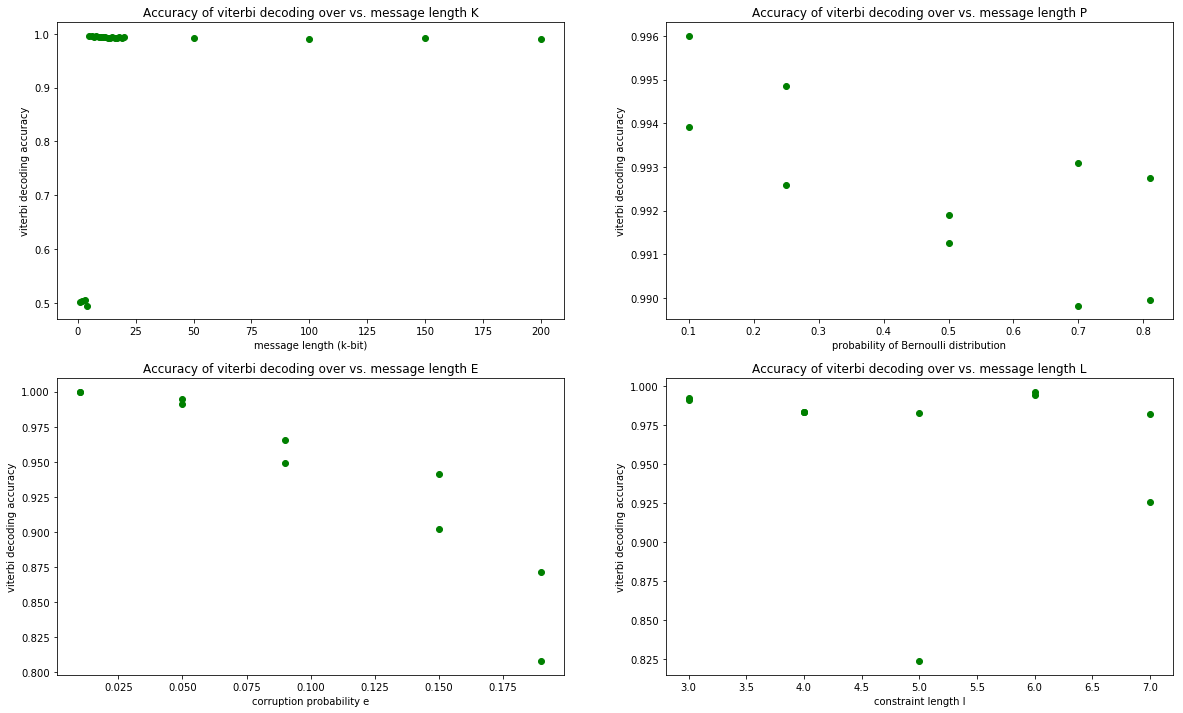

In [850]:
plt.figure(figsize=(20,12))
subplt_n = 221
root_path_format = "../data/dataset_03/exp_{0}"

for variable_name, xlabel in [("k", "message length (k-bit)"),
                              ("p", "probability of Bernoulli distribution"), 
                              ("e", "corruption probability e"), 
                              ("l", "constraint length l")]:
    plt.subplot(subplt_n)
    subplt_n += 1
    exp_path = root_path_format.format(variable_name)
    graph_viterbi_accuracy(exp_path, variable_name, xlabel=xlabel)

### Controlled experiments

In [628]:
# all_data = dict()
# for n in load_pkl_paths_from_folder("../data/dataset_03", True):
#     exp = n.split('/')[3]
#     tp = tuple([get_param_from_filename(n, y) for y in ["k","p","e","l"]])
#     if exp not in all_data:
#         all_data[exp] = dict()
#     all_data[exp][tp] = load_pkl(n)
# with open("../data/dataset_03_all_datasets_n{0}.pkl".format(2000), 'wb') as output:
#     pickle.dump(all_data, output)

In [ ]:
all_exp_data = load_pkl("../data/dataset_03_all_datasets_n2000.pkl")

In [ ]:
all_exp_data.keys()

In [ ]:
fnn_param = {
    "batch_size": 32,
    "epoch": 30,
    "verbose": 0,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.001,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}
fnn_architecture = [32,100]

In [ ]:
variable_desc

In [ ]:
title_str = "FNN-{0} Average Accuracy (N={1}) vs. {2}"
fnn_str = str(fnn_architecture)
average_N = 5

In [ ]:
all_experiment_results = dict()

for var in "elp":
    var_res = conduct_experiment(experiment_type=var, 
                                 verbose=True,
                                 data_source=all_exp_data, 
                                 architecture=fnn_architecture, 
                                 param=fnn_param, 
                                 average_N=average_N)
    all_experiment_results[var] = var_res

In [796]:
all_experiment_results

{}

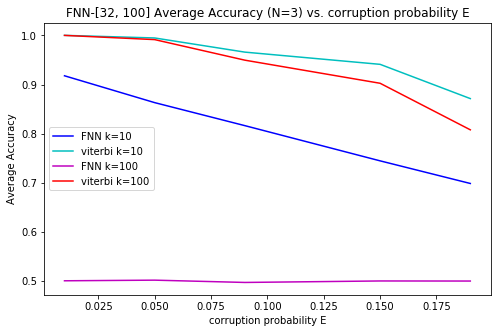

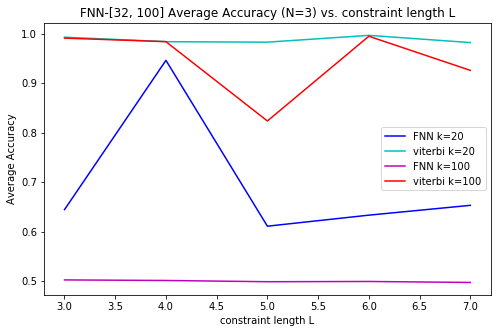

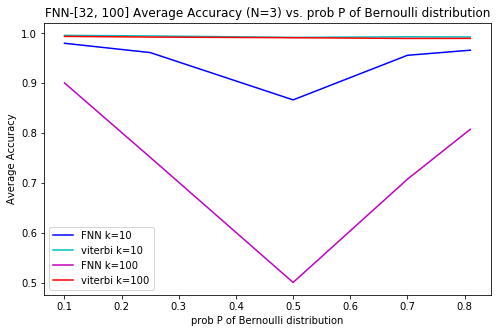

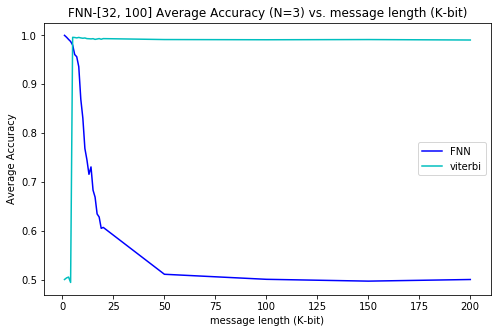

In [867]:
for var in "elpk":
    graph_experiment_accuracy(all_experiment_results[var],
                              isK=var=="k",
                              variable_name=var,
                              title=title_str.format(fnn_str, average_N, variable_desc[var]),
                              xlabel=variable_desc[var],
                              ylabel="Average Accuracy")

In [868]:
### Repeat l = 4 experiment with new data
var_res = conduct_experiment(experiment_type="l", 
                                 verbose=True,
                                 data_source=all_exp_data, 
                                 architecture=fnn_architecture, 
                                 param=fnn_param, 
                                 average_N=average_N)
x, y = build_experiment_data("l", None, all_exp_data, 
                             combine_all=False, verbose=False)
print("re-running l = 4 experiment...")
l_acc = []
for i in range(5):
    if verbose:
        print("... ... run {0}/{1}".format(i+1, average_N), end="\r")
    X_train, X_test, y_train, y_test = train_test_split(
        x[4], y[4])
    y_train = one_hot_datasets(y_train)
    model = build_fnn(input_shape=X_train.shape[1:], output_shape=y_train.shape[1:],
          architecture=fnn_architecture, param=fnn_param)
    model = train_fnn(model, X_train, y_train, param=fnn_param)
    acc = model_accuracy(model, X_test, y_test, argmax=True)
    l_acc.append(acc)
l_acc_avg = np.mean(l_acc)
print("l_acc:",l_acc)

Performing experiments over k = 20.0
... variable = 3.0
... finished with avg_acc of 0.6049
... variable = 4.0
... finished with avg_acc of 0.9493
... variable = 5.0
... finished with avg_acc of 0.5971
... variable = 6.0
... finished with avg_acc of 0.5968
... variable = 7.0
... finished with avg_acc of 0.6304
Performing experiments over k = 100.0
... variable = 3.0
... finished with avg_acc of 0.4993
... variable = 4.0
... finished with avg_acc of 0.5690
... variable = 5.0
... finished with avg_acc of 0.5010
... variable = 6.0
... finished with avg_acc of 0.4965
... variable = 7.0
... finished with avg_acc of 0.4984


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [769]:
fnn_param = {
    "batch_size": 64,
    "epoch": 15,
    "verbose": 0,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.001,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}
fnn_architecture = [32,100]
average_N = 3

In [770]:
var_res = conduct_experiment(experiment_type="k", 
                                 verbose=True,
                                 data_source=all_exp_data, 
                                 architecture=fnn_architecture, 
                                 param=fnn_param, 
                                 average_N=average_N)
all_experiment_results["k"] = var_res

Performing experiments for exp_k ...
... variable = 1.0
... ... finished with avg_acc of 1.0000
... variable = 2.0
... ... finished with avg_acc of 0.9962
... variable = 3.0
... ... finished with avg_acc of 0.9917
... variable = 4.0
... ... finished with avg_acc of 0.9875
... variable = 5.0
... ... finished with avg_acc of 0.9802
... variable = 6.0
... ... finished with avg_acc of 0.9608
... variable = 7.0
... ... finished with avg_acc of 0.9563
... variable = 8.0
... ... finished with avg_acc of 0.9360
... variable = 9.0
... ... finished with avg_acc of 0.8694
... variable = 10.0
... ... finished with avg_acc of 0.8309
... variable = 11.0
... ... finished with avg_acc of 0.7688
... variable = 12.0
... ... finished with avg_acc of 0.7456
... variable = 13.0
... ... finished with avg_acc of 0.7160
... variable = 14.0
... ... finished with avg_acc of 0.7311
... variable = 15.0
... ... finished with avg_acc of 0.6836
... variable = 16.0
... ... finished with avg_acc of 0.6694
... variable

/Users/michael-tu/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


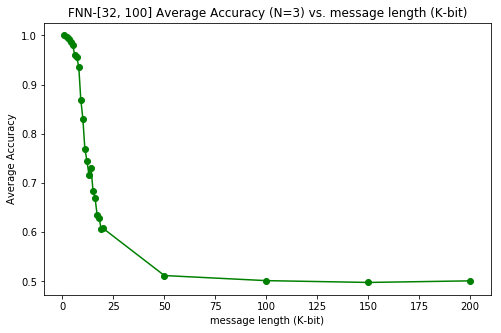

In [785]:
graph_experiment_accuracy(all_experiment_results["k"],
                          isK=True,
                          title=title_str.format(fnn_str, average_N, 
                                                 variable_desc["k"]),
                          xlabel=variable_desc["k"],
                          ylabel="Average Accuracy")

In [ ]:
# # save all models
# for var in "elp":
#     for k in all_experiment_results[var]:
#         for v in all_experiment_results[var][k]:
#             name = "models/v3/exp_{0}/k{1}_{0}{2}_fnn_{3}.h5".format(var,k,v,fnn_str)
#             all_experiment_results[var][k][v]["best_model"].save(name)
            
# for v in all_experiment_results["k"]:
#     name = "models/v3/exp_k/k{0}_fnn_{1}.h5".format(v,fnn_str)
#     all_experiment_results["k"][v]["best_model"].save(name)

In [854]:

all_experiment_results = dict()


all_experiment_results["e"] = dict()
all_experiment_results["e"][10] = dict()
all_experiment_results["e"][100] = dict()

e = [0.01, 0.05, 0.09, 0.15, 0.19]

a = [0.9178000000000001,0.8632000000000002,0.8164,0.7447999999999999,0.6988]
for i in range(len(a)):
    all_experiment_results["e"][10][e[i]] = dict(avg_acc=a[i])


a = [0.50092,0.502205,0.49755000000000005,0.50057,0.5004050000000001]
for i in range(len(a)):
    all_experiment_results["e"][100][e[i]] = dict(avg_acc=a[i])


all_experiment_results["l"] = dict()
all_experiment_results["l"][20] = dict()
all_experiment_results["l"][100] = dict()

l = np.arange(3, 8)

a = [0.644425,0.9460750000000001,0.61095,0.6332500000000001,0.653075]

for i in range(len(a)):
    all_experiment_results["l"][20][l[i]] = dict(avg_acc=a[i])


a = [0.5023949999999999,0.5012549999999999,0.4987450000000001,0.499235,0.49727999999999994]
for i in range(len(a)):
    all_experiment_results["l"][100][l[i]] = dict(avg_acc=a[i])


all_experiment_results["p"] = dict()
all_experiment_results["p"][10] = dict()
all_experiment_results["p"][100] = dict()

p = [0.1, 0.25, 0.5, 0.7, 0.81]

a = [0.9801500000000001,0.9614999999999998,0.86675,0.9560500000000001,0.9662499999999999]
for i in range(len(a)):
    all_experiment_results["p"][10][p[i]] = dict(avg_acc=a[i])


a = [0.9007249999999999,0.7516550000000001,0.501065,0.707865,0.80785]
for i in range(len(a)):
    all_experiment_results["p"][100][p[i]] = dict(avg_acc=a[i])

all_experiment_results["k"] = dict()

ks = np.hstack([np.arange(1, 21, 1), np.arange(50, 201, 50)])

a = [1.0000,0.9962,0.9917,0.9875,0.9802,0.9608,0.9563,0.9360,0.8694,0.8309,0.7688,0.7456,0.7160,0.7311,0.6836,0.6694,0.6350,0.6287,0.6056,0.6075,0.5117,0.5014,0.4977,0.5010]

for i in range(len(a)):
    all_experiment_results["k"][ks[i]] = dict(avg_acc=a[i])

In [855]:
all_experiment_results

{'e': {10: {0.01: {'avg_acc': 0.9178000000000001},
   0.05: {'avg_acc': 0.8632000000000002},
   0.09: {'avg_acc': 0.8164},
   0.15: {'avg_acc': 0.7447999999999999},
   0.19: {'avg_acc': 0.6988}},
  100: {0.01: {'avg_acc': 0.50092},
   0.05: {'avg_acc': 0.502205},
   0.09: {'avg_acc': 0.49755000000000005},
   0.15: {'avg_acc': 0.50057},
   0.19: {'avg_acc': 0.5004050000000001}}},
 'k': {1: {'avg_acc': 1.0},
  2: {'avg_acc': 0.9962},
  3: {'avg_acc': 0.9917},
  4: {'avg_acc': 0.9875},
  5: {'avg_acc': 0.9802},
  6: {'avg_acc': 0.9608},
  7: {'avg_acc': 0.9563},
  8: {'avg_acc': 0.936},
  9: {'avg_acc': 0.8694},
  10: {'avg_acc': 0.8309},
  11: {'avg_acc': 0.7688},
  12: {'avg_acc': 0.7456},
  13: {'avg_acc': 0.716},
  14: {'avg_acc': 0.7311},
  15: {'avg_acc': 0.6836},
  16: {'avg_acc': 0.6694},
  17: {'avg_acc': 0.635},
  18: {'avg_acc': 0.6287},
  19: {'avg_acc': 0.6056},
  20: {'avg_acc': 0.6075},
  50: {'avg_acc': 0.5117},
  100: {'avg_acc': 0.5014},
  150: {'avg_acc': 0.4977},
  200